### Descarcam setul de date

In [9]:
!pip install opendatasets --upgrade --quiet

In [10]:
import opendatasets as od

In [11]:
dataset_url = 'https://www.kaggle.com/datasets/sarasnchez/monkeys'

In [12]:
# import os
# import shutil

# if os.path.exists('./monkeys'):
#     shutil.rmtree('./monkeys')

In [13]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gabysalajan
Your Kaggle Key: ··········


100%|██████████| 2.84M/2.84M [00:00<00:00, 4.09MB/s]


In [14]:
data_dir = './monkeys/Monkeys'

In [15]:
import os

Afisam folderele din setul de date pentru a ne asigura ca este structurat corespunzator

In [16]:
os.listdir(data_dir)

['Mandril',
 'White face saki',
 'Proboscis Monkey',
 'Bald Uakari',
 'Emperor Tamarin']

Verificam cate imagini contine fiecare clasa (specie de maimute)

In [17]:
for species in os.listdir(data_dir):
    print(species, ':', len(os.listdir(data_dir + '/' + species)))

Mandril : 100
White face saki : 100
Proboscis Monkey : 100
Bald Uakari : 100
Emperor Tamarin : 100


### Importam setul de date in PyTorch
Folosim clasa ImageFolder pentru a prelua setul de date care este reprezentat de imagini clasificate in foldere.



In [18]:
from torchvision.datasets import ImageFolder

In [19]:
dataset = ImageFolder(data_dir)

In [20]:
len(dataset)

500

In [21]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=160x160 at 0x7FBAF115D1B0>, 0)

In [22]:
dataset.classes

['Bald Uakari',
 'Emperor Tamarin',
 'Mandril',
 'Proboscis Monkey',
 'White face saki']

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

Emperor Tamarin


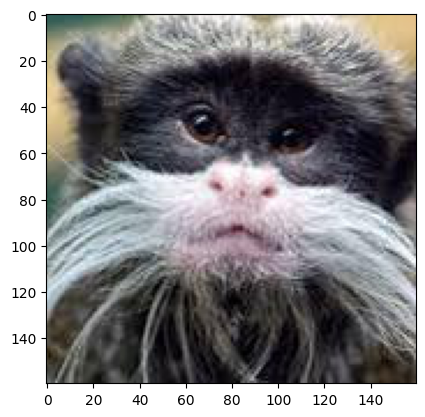

In [24]:
img, label = dataset[120]
plt.imshow(img)
print(dataset.classes[label])

Aplicam transformari asupra setului de date pentru a le aduce pe toate la aceleasi dimensiuni si le convertim la tensor.

> 64x64 pentru a nu ramane fara memorie



In [25]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

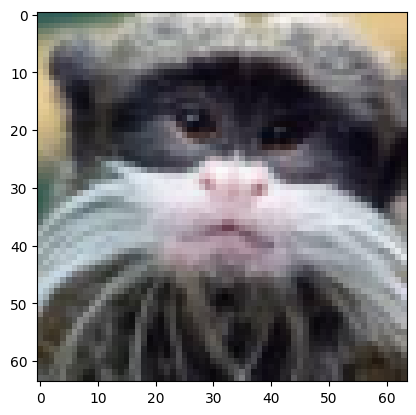

In [26]:
img, label = dataset[120]
#facem permutare deoarece imaginea originala era H x W x C, iar tensor este C x H x W
plt.imshow(img.permute((1, 2, 0)))

Impartim setul de date in 2 parti, una pentru training(90%) si una pentru validare(10%)

In [27]:
validation_percent = 0.1

validation_size = int(validation_percent * len(dataset))
train_size = len(dataset) - validation_size

train_size, validation_size

(450, 50)

In [28]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, validation_size])
len(train_ds), len(valid_ds)

(450, 50)

Cream cate un data loader pentru fiecare set pentru a putea incarca seturile in model, de asemenea data loader-ul optimizeaza procesul de incarcare a datelor in model.

In [29]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=2, 
                    pin_memory=True)

Afisam imaginile din setul de training

In [30]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

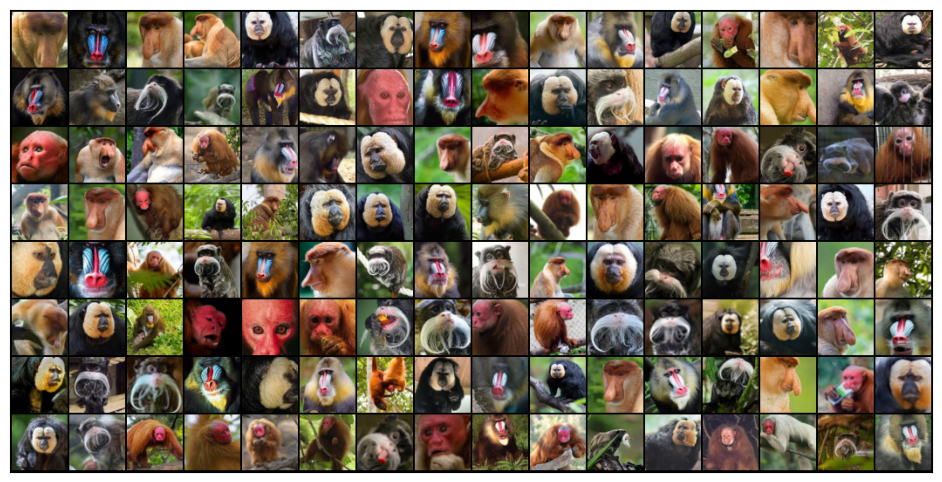

In [31]:
show_batch(train_dl)

### GPU si Utilitati

####GPU
Setam data loader-ele sa incarce imaginile pe placa video daca este disponibila pentru a avea o performanta imbunatatita

In [32]:
import torch

def get_default_device():
    """Alege placa video daca este disponibila"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Muta tensorii pe device-ul disponibil"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Seteaza device-ul pe care data loader-ul sa incarce datele"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Produce un set de date dupa ce le muta pe device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Numarul de seturi"""
        return len(self.dl)


In [33]:
torch.cuda.is_available()

True

In [34]:
device = get_default_device()

In [35]:
device

device(type='cuda')

In [36]:
img, label = dataset[0]

In [37]:
img.device

device(type='cpu')

In [38]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [39]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

####Definim clasa de baza care ne va servi ca fundatie pentru a construi un model care clasifica imaginile

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class BaseClass(nn.Module):

    def training_step(self, batch):
        "Calculam pierderea pentru un set de date de training"
        images, labels = batch 
        out = self(images)                  # Genereaza predictii
        loss = F.cross_entropy(out, labels) # Calculeaza pierderea
        return loss
    
    def validation_step(self, batch):
        "Calculeaza pierderea si acuratetea pentru un set de date de validare"
        images, labels = batch 
        out = self(images)                    # Genereaza predictii
        loss = F.cross_entropy(out, labels)   # Calculeaza pierderea
        acc = accuracy(out, labels)           # Calculeaza acuratetea
        return {'pierdere_validare': loss.detach(), 'acuratete_validare': acc}
        
    def validation_epoch_end(self, outputs):
        "Calculeaza media pentru pierdere si acuratete pentru o epoca"

        batch_loss = [x['pierdere_validare'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()   # Combina pierderile

        batch_acc = [x['acuratete_validare'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()     # Combina acuratetea

        return {'pierdere_validare': epoch_loss.item(), 'acuratete_validare': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoca [{}], pierdere_antrenare: {:.4f}, pierdere_validare: {:.4f}, acuratete_validare: {:.4f}".format(
            epoch, result['pierdere_antrenare'], result['pierdere_validare'], result['acuratete_validare']))
        
def accuracy(outputs, labels):
    "Calculeaza acuratetea tinand cont de rezultatele modelului si etichetele adevarate"
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [41]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evalueaza performanta modelului pe setul de validare"""

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

def fit(epochs, learn_rate, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    "Antreneaza modelul"

    history = []
    optimizer = opt_func(model.parameters(), learn_rate)

    for epoch in range(epochs):

        #Training 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Validare
        result = evaluate(model, val_loader)
        result['pierdere_antrenare'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

## Model
Clasa ResNet9 reprezinta o implementare specifica a unei retele neuronale convolutionale de tip ResNet-9 in PyTorch.

net.svg

In [42]:
def conv_block(in_channels, out_channels, pool=False):
    "Creeaza un bloc convolutional standard in care se aplica o convolutie,"
    "o normalizare a setului si o funcție de activare ReLU. "
    "Optional, poate fi adaugat si un strat de Pooling"

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: 
      layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

    

class ResNet9(BaseClass):

    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [43]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [44]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Trimitem un set de intrare prin model.

In [45]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


### Training

Rezultate inainte de antrenare

In [46]:
history = [evaluate(model, valid_dl)]
history

[{'pierdere_validare': 1.6130001544952393,
  'acuratete_validare': 0.11999999731779099}]

Antrenare

In [47]:
history += fit(5, 0.001, model, train_dl, valid_dl)

Epoca [0], pierdere_antrenare: 2.2397, pierdere_validare: 1.6103, acuratete_validare: 0.2200
Epoca [1], pierdere_antrenare: 1.4651, pierdere_validare: 1.6201, acuratete_validare: 0.2200
Epoca [2], pierdere_antrenare: 1.1758, pierdere_validare: 1.6405, acuratete_validare: 0.2200
Epoca [3], pierdere_antrenare: 1.0168, pierdere_validare: 1.6574, acuratete_validare: 0.2200
Epoca [4], pierdere_antrenare: 0.7915, pierdere_validare: 1.7198, acuratete_validare: 0.2200


In [48]:
history += fit(10, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoca [0], pierdere_antrenare: 2.2402, pierdere_validare: 17.6990, acuratete_validare: 0.1600
Epoca [1], pierdere_antrenare: 1.0229, pierdere_validare: 11.9806, acuratete_validare: 0.3200
Epoca [2], pierdere_antrenare: 0.5389, pierdere_validare: 4.7867, acuratete_validare: 0.5200
Epoca [3], pierdere_antrenare: 0.3567, pierdere_validare: 1.8555, acuratete_validare: 0.6800
Epoca [4], pierdere_antrenare: 0.3316, pierdere_validare: 0.8644, acuratete_validare: 0.7600
Epoca [5], pierdere_antrenare: 0.2395, pierdere_validare: 0.5628, acuratete_validare: 0.8000
Epoca [6], pierdere_antrenare: 0.1822, pierdere_validare: 0.3845, acuratete_validare: 0.8400
Epoca [7], pierdere_antrenare: 0.1600, pierdere_validare: 0.3387, acuratete_validare: 0.8600
Epoca [8], pierdere_antrenare: 0.1415, pierdere_validare: 0.3116, acuratete_validare: 0.8600
Epoca [9], pierdere_antrenare: 0.1156, pierdere_validare: 0.2155, acuratete_validare: 0.9000


In [49]:
history += fit(10, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoca [0], pierdere_antrenare: 0.0698, pierdere_validare: 0.1756, acuratete_validare: 0.9200
Epoca [1], pierdere_antrenare: 0.0622, pierdere_validare: 0.1739, acuratete_validare: 0.9200
Epoca [2], pierdere_antrenare: 0.0522, pierdere_validare: 0.1607, acuratete_validare: 0.9000
Epoca [3], pierdere_antrenare: 0.0366, pierdere_validare: 0.1241, acuratete_validare: 0.9200
Epoca [4], pierdere_antrenare: 0.0451, pierdere_validare: 0.1111, acuratete_validare: 0.9200
Epoca [5], pierdere_antrenare: 0.0262, pierdere_validare: 0.1186, acuratete_validare: 0.9200
Epoca [6], pierdere_antrenare: 0.0185, pierdere_validare: 0.1417, acuratete_validare: 0.9400
Epoca [7], pierdere_antrenare: 0.0156, pierdere_validare: 0.1470, acuratete_validare: 0.9400
Epoca [8], pierdere_antrenare: 0.0160, pierdere_validare: 0.1419, acuratete_validare: 0.9400
Epoca [9], pierdere_antrenare: 0.0117, pierdere_validare: 0.1013, acuratete_validare: 0.9400


In [50]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoca [0], pierdere_antrenare: 0.0142, pierdere_validare: 0.1008, acuratete_validare: 0.9200
Epoca [1], pierdere_antrenare: 0.0107, pierdere_validare: 0.1029, acuratete_validare: 0.9200
Epoca [2], pierdere_antrenare: 0.0108, pierdere_validare: 0.1055, acuratete_validare: 0.9400
Epoca [3], pierdere_antrenare: 0.0101, pierdere_validare: 0.1055, acuratete_validare: 0.9400
Epoca [4], pierdere_antrenare: 0.0125, pierdere_validare: 0.1065, acuratete_validare: 0.9600


In [51]:
def plot_accuracies(history):
    accuracies = [x['acuratete_validare'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoca')
    plt.ylabel('acuratete')
    plt.title('Acuratetea per epoca');

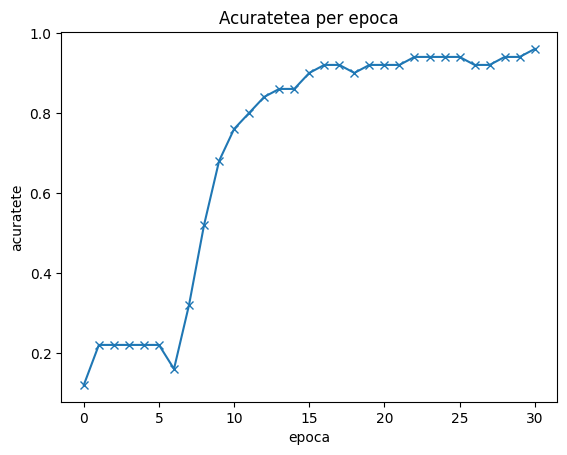

In [52]:
plot_accuracies(history)

In [53]:
def plot_losses(history):
    train_losses = [x.get('pierdere_antrenare') for x in history]
    val_losses = [x['pierdere_validare'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoca')
    plt.ylabel('pierdere')
    plt.legend(['Training', 'Validare'])
    plt.title('Pierderea per epoca');

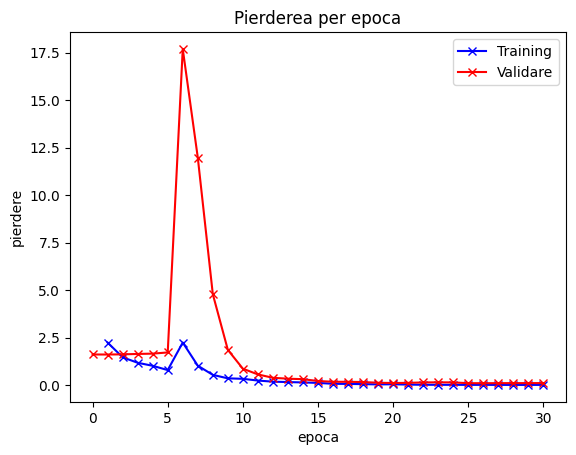

In [54]:
plot_losses(history)

### Rezultate

In [55]:
history[-1]

{'pierdere_validare': 0.1064702719449997,
 'acuratete_validare': 0.9599999785423279,
 'pierdere_antrenare': 0.012516876682639122}

### Teste cu diferite imagini




In [56]:
def predict_image(img, model, classes):

    # Convertim intrarea la un set de 1 imagine
    xb = to_device(img.unsqueeze(0), device)

    # Facem predictia
    yb = model(xb)

    # Algeme index-ul cu cea mai mare probabilitate
    _, preds  = torch.max(yb, dim=1)
    
    # Returnam numele clasei
    return classes[preds[0].item()]

In [57]:
def show_image_prediction(img, label):
  
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)

    print('Valoare reala:', dataset.classes[label])
    print('Predictie:', pred)

In [58]:
len(valid_ds)

50

Valoare reala: Mandril
Predictie: Mandril


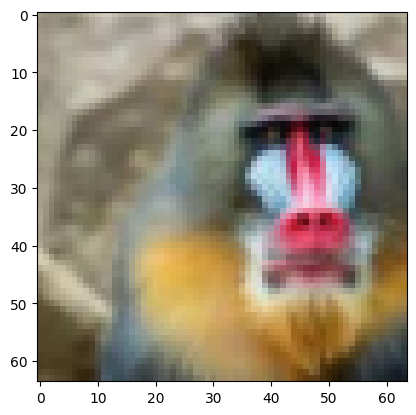

In [59]:
show_image_prediction(*valid_ds[49])

Valoare reala: White face saki
Predictie: White face saki


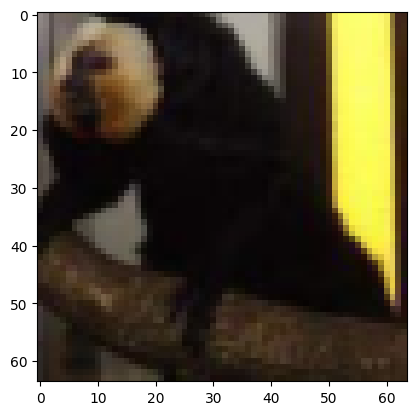

In [60]:
show_image_prediction(*valid_ds[33])

Valoare reala: White face saki
Predictie: White face saki


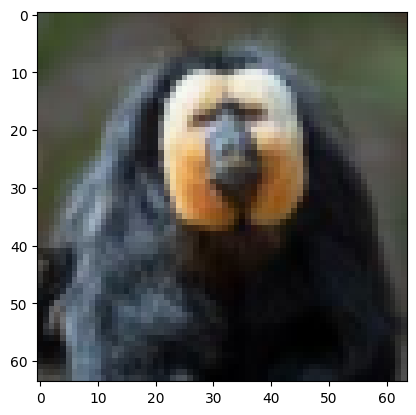

In [61]:
show_image_prediction(*valid_ds[17])

Valoare reala: Mandril
Predictie: Mandril


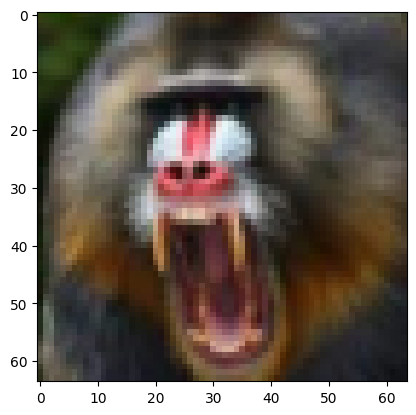

In [62]:
show_image_prediction(*valid_ds[14])

Valoare reala: Proboscis Monkey
Predictie: Proboscis Monkey


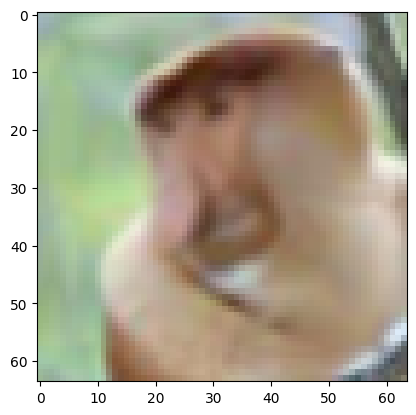

In [63]:
show_image_prediction(*valid_ds[11])

In [64]:
torch.save(model.state_dict(), 'monkey_model.pth')